# Семинар 2: Фильтры сглаживания и выделение границ

Во второй семинарской работе мы рассмотрим, как уменьшить шумы и выделить границы на изображениях с помощью простых фильтров.

**Цели занятия:**

- научиться применять линейные и нелинейные сглаживающие фильтры;
- познакомиться с операторами Собеля и Лапласа для выделения границ;
- проанализировать влияние фильтрации на качество границ.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Вспомогательная функция для отображения
def show_images(images, titles=None, cols=3, figsize=(32,16), cmap=None, font_size=12):
    """Отображает несколько изображений с возможностью настройки размера шрифта для заголовков."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap=cmap or 'gray')
        else:
            # cv2 читает изображения в формате BGR; для отображения переводим в RGB
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles and i < len(titles):
            plt.title(titles[i], fontsize=font_size)  # ← Новый параметр font_size
        plt.axis('off')
    plt.tight_layout()
    plt.show()

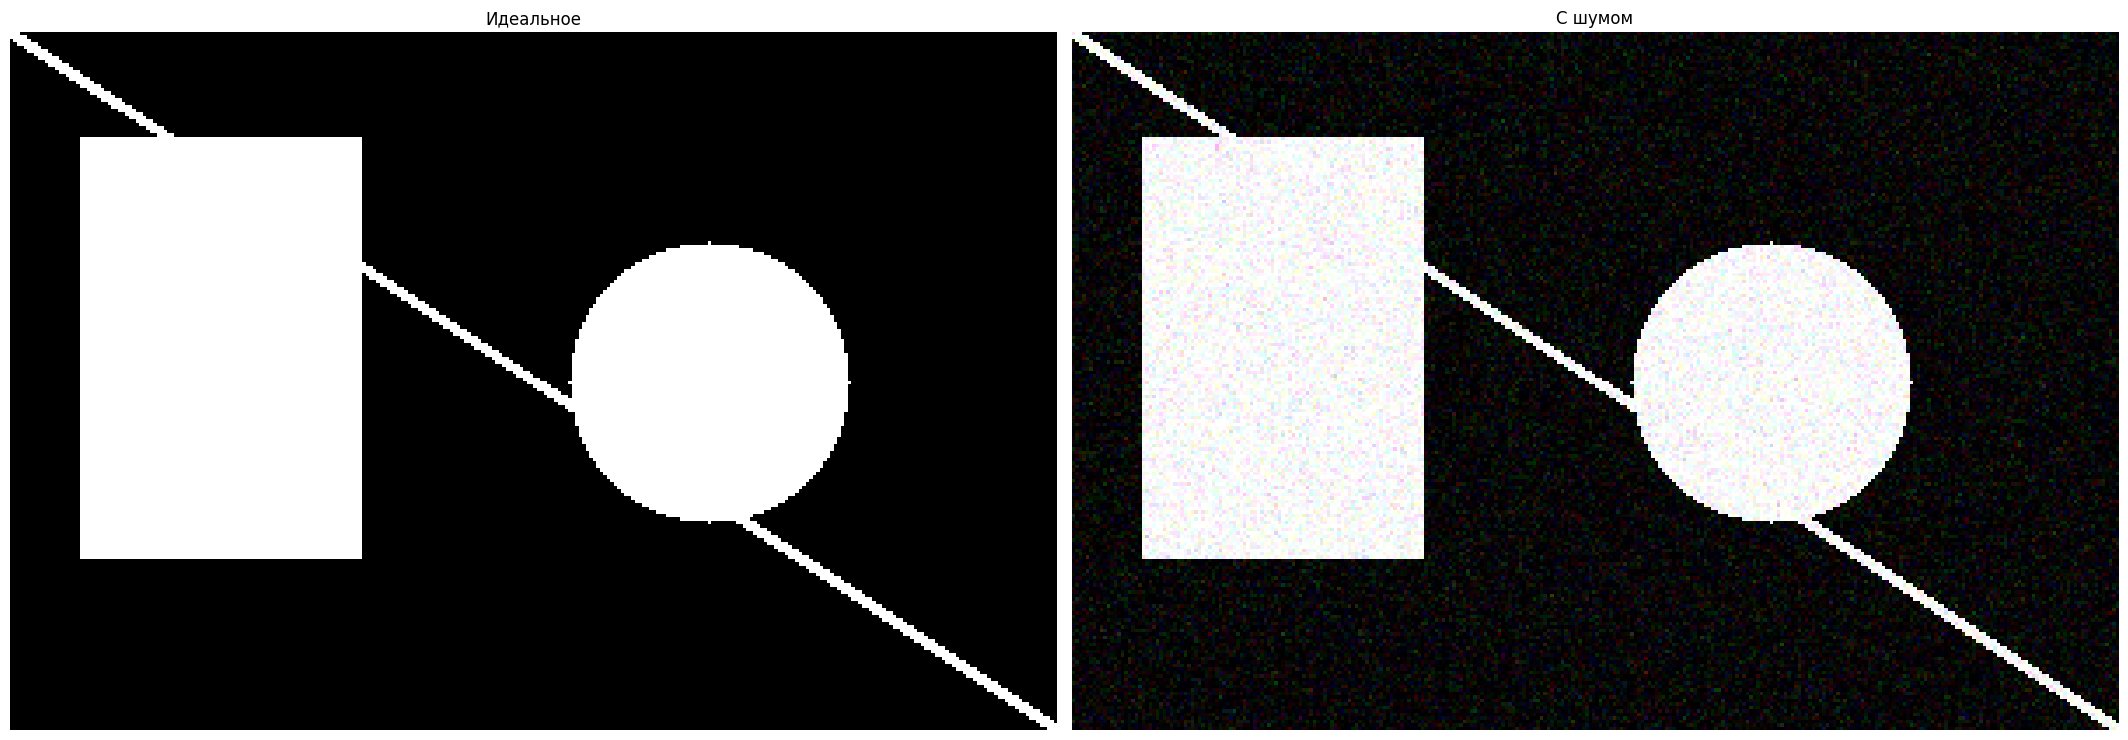

In [7]:
# Сгенерируем изображение с геометрическими объектами и добавим шум
img = np.zeros((200, 300, 3), dtype=np.uint8)
# белый прямоугольник
cv2.rectangle(img, (20, 30), (100, 150), (255,255,255), -1)
# круг
cv2.circle(img, (200, 100), 40, (255,255,255), -1)
# диагональная белая линия
cv2.line(img, (0,0), (299,199), (255,255,255), 2)
# Добавим гауссов шум
noise = np.random.normal(0, 20, img.shape).astype(np.int16)
noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
show_images([img, noisy_img], ['Идеальное', 'С шумом'])

## Сглаживающие фильтры

Попробуем несколько фильтров:

* **Усредняющий фильтр (box filter)** — заменяет каждый пиксель средним по окрестности.
* **Гауссов фильтр** — веса в ядре выбираются по нормальному распределению; лучше подавляет шум, сохраняя края.
* **Медианный фильтр** — нелинейный фильтр: значение заменяется медианой соседних пикселей; хорош при импульсных шумах.


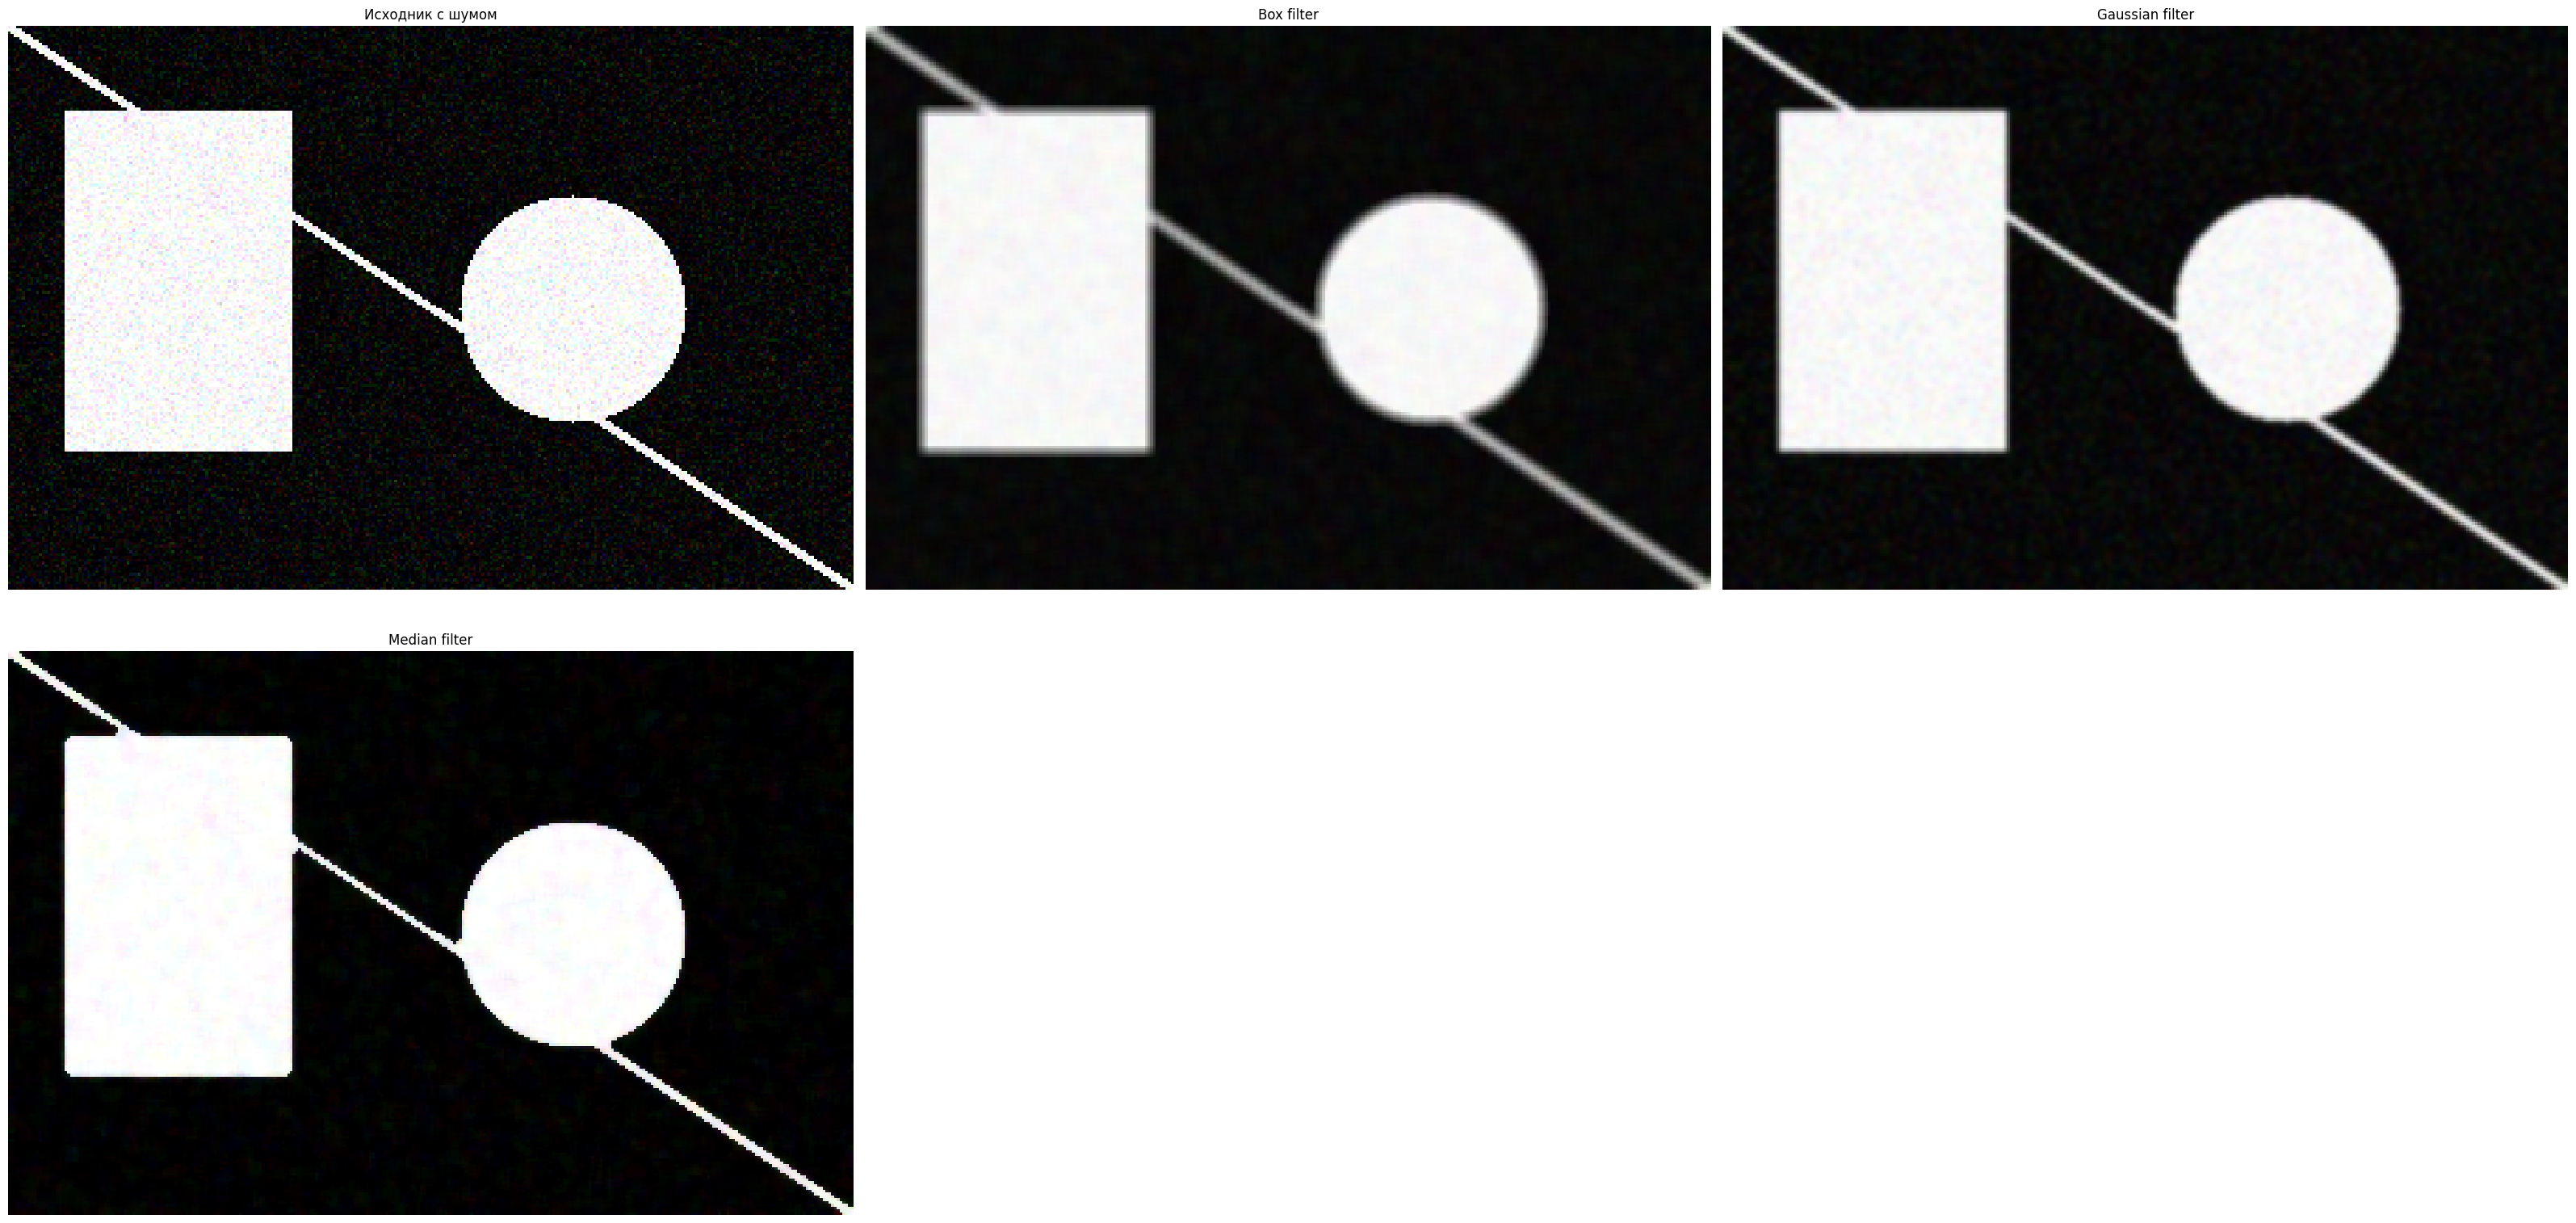

In [8]:
# Усредняющий фильтр
blur = cv2.blur(noisy_img, (5,5))
# Гауссов фильтр
gauss = cv2.GaussianBlur(noisy_img, (5,5), sigmaX=1.0)
# Медианный фильтр
median = cv2.medianBlur(noisy_img, 5)
show_images([noisy_img, blur, gauss, median], ['Исходник с шумом', 'Box filter', 'Gaussian filter', 'Median filter'])

## Конволюция и пользовательские ядра

Мы можем создавать собственные ядра фильтрации. Например, ядро выделения резкости (sharpening kernel) усиливает переходы между пикселями:

$\begin{bmatrix} 0 & -1 & 0 \cr -1 & 5 & -1 \cr 0 & -1 & 0 \end{bmatrix}$

Эта операция вычисляется с помощью `cv2.filter2D`.

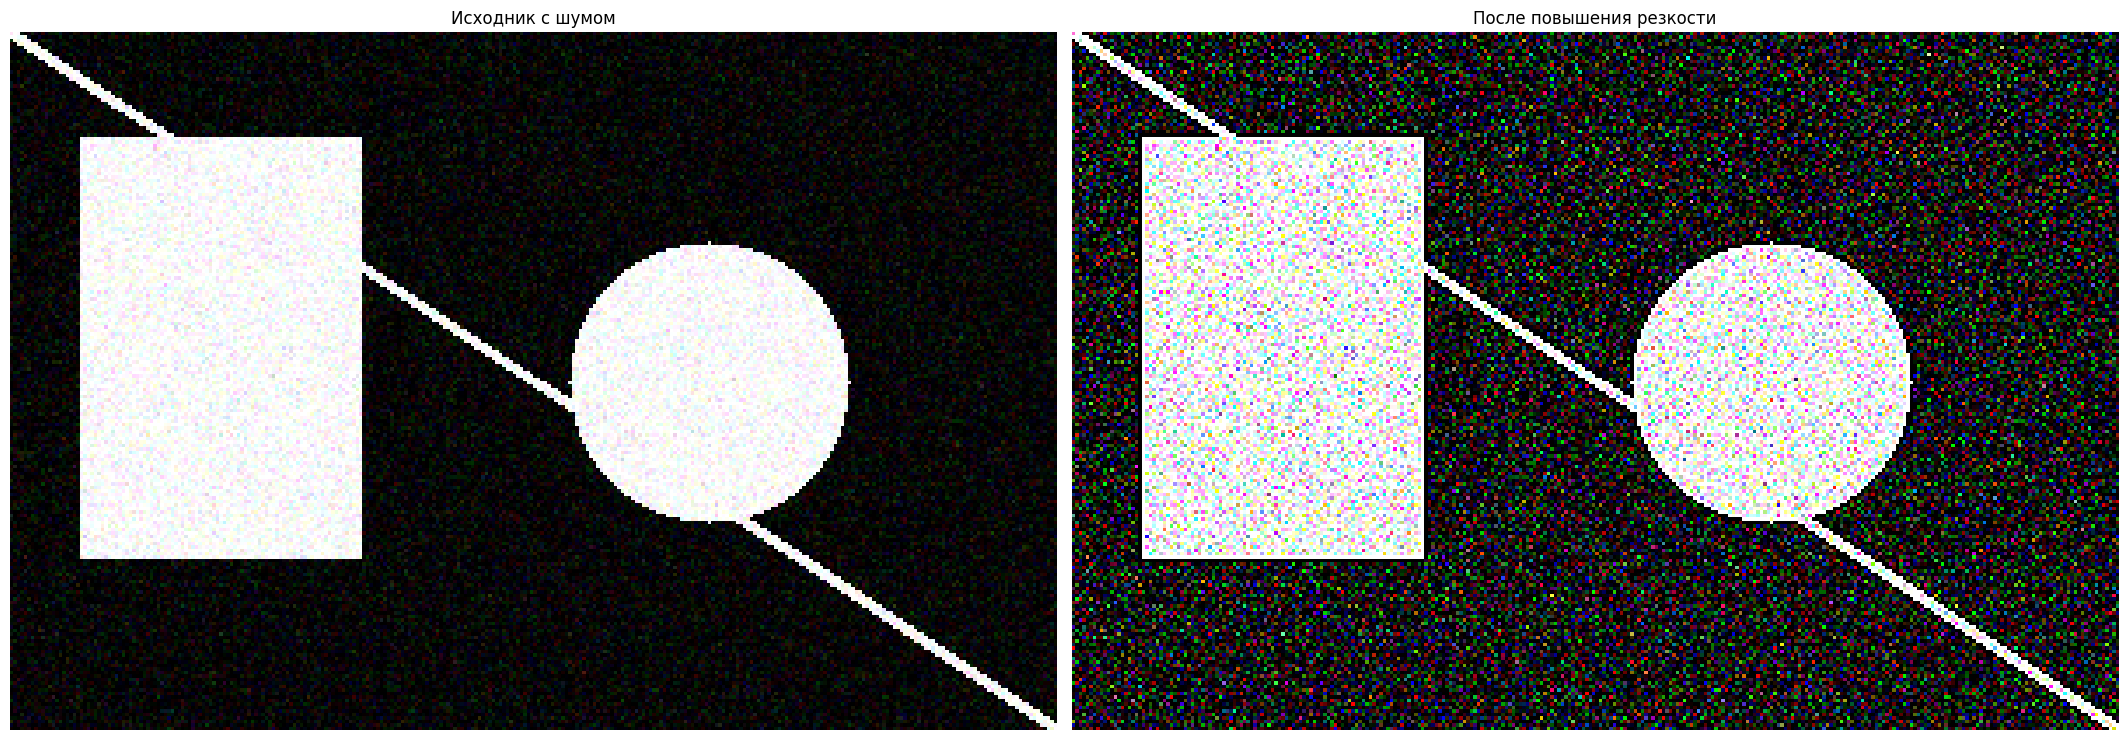

In [9]:
# Пользовательский фильтр (sharpening kernel)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
sharpen = cv2.filter2D(noisy_img, -1, kernel)
show_images([noisy_img, sharpen], ['Исходник с шумом', 'После повышения резкости'])

## Выделение границ

Для обнаружения границ используются производные по горизонтали и вертикали. Наиболее распространённые операторы — Собеля и Лапласа.
* **Оператор Собеля** использует два ядра для выделения горизонтальной и вертикальной производных, после чего обычно вычисляется модуль градиента.
* **Фильтр Лапласа** использует вторую производную для нахождения точек с максимальным изменением яркости.

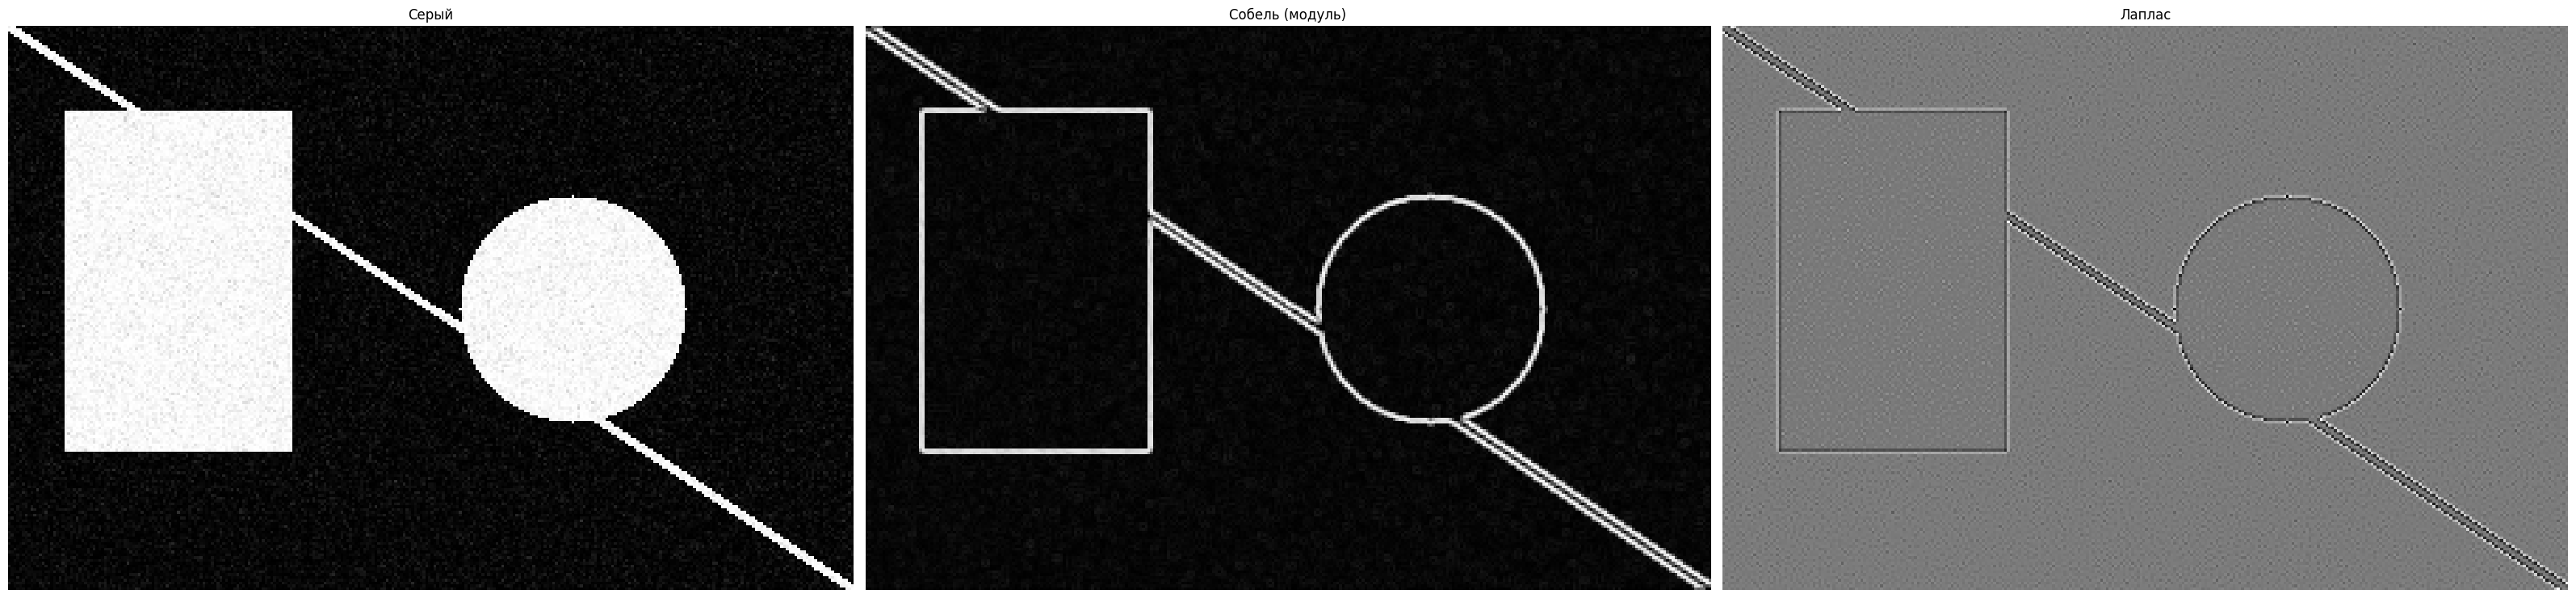

In [10]:
# Оператор Собеля
# градиенты по X и Y
gray = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
# модуль градиента
grad_mag = cv2.magnitude(sobelx, sobely)
grad_mag = np.uint8(cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX))

# Фильтр Лапласа
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
laplacian_norm = np.uint8(cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX))

show_images([gray, grad_mag, laplacian_norm], ['Серый', 'Собель (модуль)', 'Лаплас'])

## Выводы

* Простые линейные и нелинейные фильтры помогают уменьшить шум, но могут размывать края.
* Оператор Собеля выделяет ориентации границ; Laplacian обнаруживает места с сильным изменением яркости.
* Попробуйте изменить размеры ядра и значения sigma в GaussianBlur, чтобы увидеть, как меняется баланс между шумоподавлением и сохранением деталей.